In [ ]:
%pip install pandas
%pip install matplotlib
%pip install seaborn

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%pip install lightgbm
%pip install joblib

In [ ]:
%pip install scikit-learn

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

import lightgbm as lgb
import joblib

In [ ]:
data_path = "Fraud.csv"

In [ ]:
df = pd.read_csv(data_path, nrows=200000)
print("Shape:", df.shape)
df.head()

Shape: (200000, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### EDA

In [11]:
print("Columns:", df.columns.tolist())
print("\nMissing values:\n", df.isnull().sum())
print("\nClass distribution:\n", df['isFraud'].value_counts(normalize=True))
print("\nTransaction Types:\n", df['type'].value_counts())

Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

Missing values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Class distribution:
 isFraud
0    0.999265
1    0.000735
Name: proportion, dtype: float64

Transaction Types:
 type
PAYMENT     73427
CASH_OUT    66488
CASH_IN     41579
TRANSFER    16836
DEBIT        1670
Name: count, dtype: int64


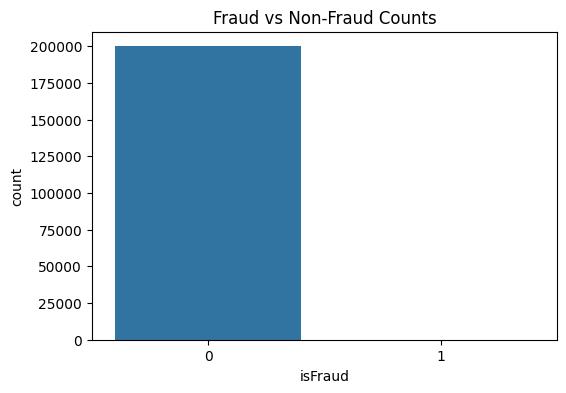

In [13]:
# fraud vs non fraud
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='isFraud')
plt.title("Fraud vs Non-Fraud Counts")
plt.show()

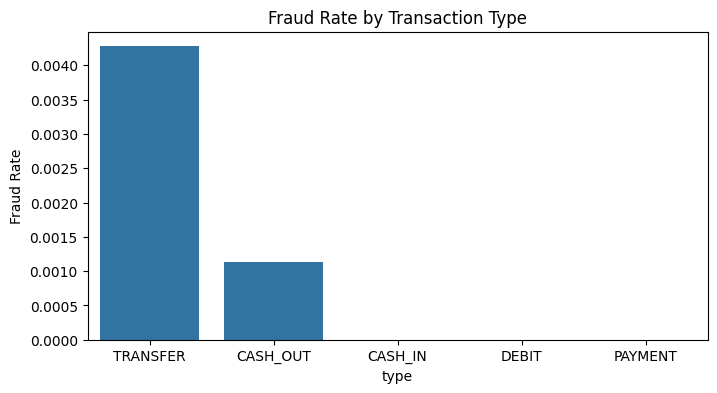

In [14]:
# Fraud rate by Transaction Type
plt.figure(figsize=(8,4))
fraud_by_type = df.groupby("type")['isFraud'].mean().sort_values(ascending=False)
sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values)
plt.title("Fraud Rate by Transaction Type")
plt.ylabel("Fraud Rate")
plt.show()

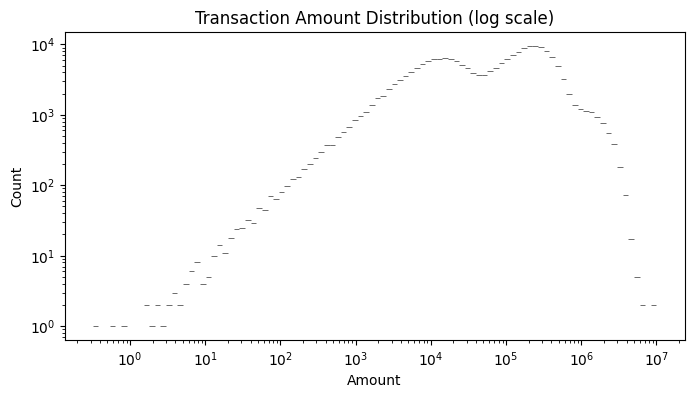

In [16]:
# Distribution of Transaction Amounts
plt.figure(figsize=(8,4))
sns.histplot(df['amount'], bins=100, log_scale=(True, True))
plt.title("Transaction Amount Distribution (log scale)")
plt.xlabel("Amount")
plt.show()


### Feature Engg

In [17]:
df = df.copy()

In [18]:
df['is_dest_merchant'] = df['nameDest'].astype(str).str.startswith('M').astype(int)

In [19]:
df['day'] = df['step'] // 24
df['amount_log'] = np.log1p(df['amount'])
df['amt_ratio'] = df['amount'] / (df['oldbalanceOrg'].replace({0:np.nan}))
df['amt_ratio'] = df['amt_ratio'].fillna(-1)

In [ ]:
# Drop id-like columns
df = df.drop(columns=['nameOrig','nameDest','newbalanceOrig','newbalanceDest'])
print("Features after engineering:\n", df.head())

Features after engineering:
    step      type    amount  oldbalanceOrg  oldbalanceDest  isFraud  \
0     1   PAYMENT   9839.64       170136.0             0.0        0   
1     1   PAYMENT   1864.28        21249.0             0.0        0   
2     1  TRANSFER    181.00          181.0             0.0        1   
3     1  CASH_OUT    181.00          181.0         21182.0        1   
4     1   PAYMENT  11668.14        41554.0             0.0        0   

   isFlaggedFraud  is_dest_merchant  day  amount_log  amt_ratio  
0               0                 1    0    9.194276   0.057834  
1               0                 1    0    7.531166   0.087735  
2               0                 0    0    5.204007   1.000000  
3               0                 0    0    5.204007   1.000000  
4               0                 1    0    9.364703   0.280795  


In [ ]:
# feature engg. label encoding on categorical data (output cell only)
le = LabelEncoder()
df['type_enc'] = le.fit_transform(df['type'].astype(str))
df = df.drop(columns=['type'])

# Features and target
X = df.drop(columns=['isFraud','isFlaggedFraud'])
y = df['isFraud']
print("Feature columns:", X.columns.tolist())


Feature columns: ['step', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'is_dest_merchant', 'day', 'amount_log', 'amt_ratio', 'type_enc']


In [22]:
# Train-Test Split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, " Valid shape:", X_valid.shape)


Train shape: (160000, 9)  Valid shape: (40000, 9)


In [24]:
#  Train LightGBM Model
scale_pos_weight = (len(y_train) - y_train.sum()) / max(1,y_train.sum())
lgbm = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)
from lightgbm import early_stopping, log_evaluation

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc',
    callbacks=[early_stopping(20), log_evaluation(10)]
)


[LightGBM] [Info] Number of positive: 118, number of negative: 159882
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1296
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000737 -> initscore=-7.211507
[LightGBM] [Info] Start training from score -7.211507
Training until validation scores don't improve for 20 rounds
[10]	valid_0's auc: 0.835731	valid_0's binary_logloss: 1.79221
[20]	valid_0's auc: 0.933971	valid_0's binary_logloss: 1.31059
Early stopping, best iteration is:
[1]	valid_0's auc: 0.999752	valid_0's binary_logloss: 0.190627


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [25]:
y_prob = lgbm.predict_proba(X_valid)[:,1]
y_pred = (y_prob > 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_valid, y_prob))

ROC AUC: 0.9972480048034825


In [26]:
# Precision-Recall AUC
precision, recall, thresholds = precision_recall_curve(y_valid, y_prob)
pr_auc = auc(recall, precision)
print("PR AUC:", pr_auc)

PR AUC: 0.5582329317269077


In [27]:
print("\nConfusion Matrix:\n", confusion_matrix(y_valid, y_pred))
print("\nClassification Report:\n", classification_report(y_valid, y_pred, digits=4))


Confusion Matrix:
 [[39751   220]
 [    0    29]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9945    0.9972     39971
           1     0.1165    1.0000    0.2086        29

    accuracy                         0.9945     40000
   macro avg     0.5582    0.9972    0.6029     40000
weighted avg     0.9994    0.9945    0.9967     40000



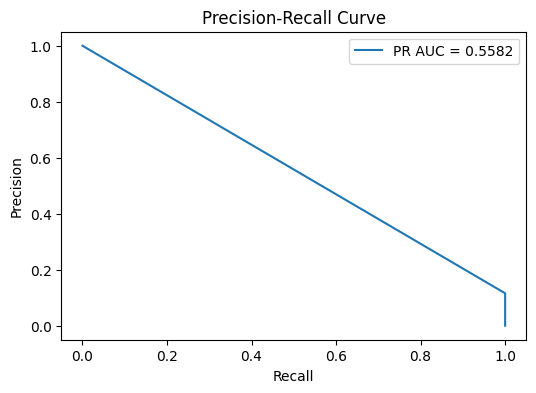

In [28]:
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [30]:
def precision_at_k(y_true, y_scores, k=0.01):
    n = int(len(y_scores) * k)
    idx = np.argsort(y_scores)[::-1][:n]
    return y_true.iloc[idx].mean()

for k in [0.01, 0.005, 0.001]:
    print(f"Precision at top {k*100:.1f}%:", precision_at_k(y_valid.reset_index(drop=True), y_prob, k))


Precision at top 1.0%: 0.0725
Precision at top 0.5%: 0.12
Precision at top 0.1%: 0.15


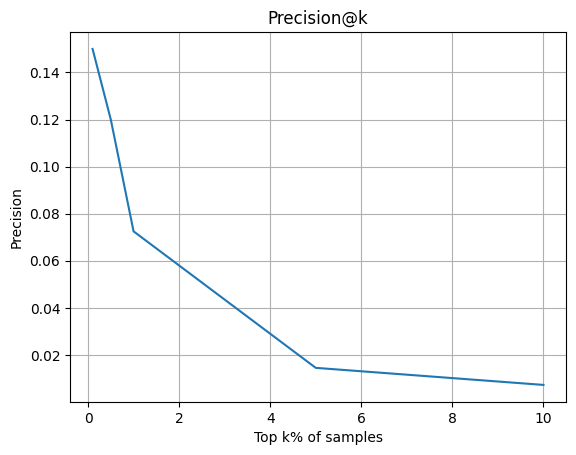

In [32]:
def precision_at_k(y_true, y_scores, k=0.01):
    n = int(len(y_scores) * k)
    idx = np.argsort(y_scores)[::-1][:n]
    return y_true.iloc[idx].mean()

ks = [0.001, 0.005, 0.01, 0.05, 0.1]
precisions = [precision_at_k(y_valid.reset_index(drop=True), y_prob, k) for k in ks]

plt.plot([k*100 for k in ks], precisions)
plt.xlabel("Top k% of samples")
plt.ylabel("Precision")
plt.title("Precision@k")
plt.grid(True)
plt.show()